In [1]:
#import multiprocessing
import LibAu as la
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py as h5
import warnings
warnings.filterwarnings('ignore')

In [2]:
km2kpc=3.24078e-17
def AngMom(dat):#rxv
    #print(dat.shape)
    dat[:,3]=dat[:,3]*km2kpc
    dat[:,4]=dat[:,4]*km2kpc
    dat[:,5]=dat[:,5]*km2kpc
    rxv = np.cross(dat[:,:3],dat[:,3:6])* dat[:,6].reshape((dat[:,6].size,1))
    #Li = (dat[:,1]*dat[:,5] - dat[:,2]*dat[:,4]) * dat[:,6]
    #Lj = (dat[:,2]*dat[:,3] - dat[:,0]*dat[:,5]) * dat[:,6]
    #Lk = (dat[:,0]*dat[:,4] - dat[:,1]*dat[:,3]) * dat[:,6]
    #Lx,Ly,Lz = np.sum(Li),np.sum(Lj),np.sum(Lk)
    return np.sum(rxv,axis=0)#np.array([Lx,Ly,Lz])

In [3]:
la.L3MHDsam

[16, 21, 23, 24, 27, 6]

Au-16 snapshot 60
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  29509636 29517119
Lambda_stars:  0.000	0.010	0.150
Lambda_gas:  -0.020	0.074	0.463
Lambda_dm:  -0.024	0.036	0.050


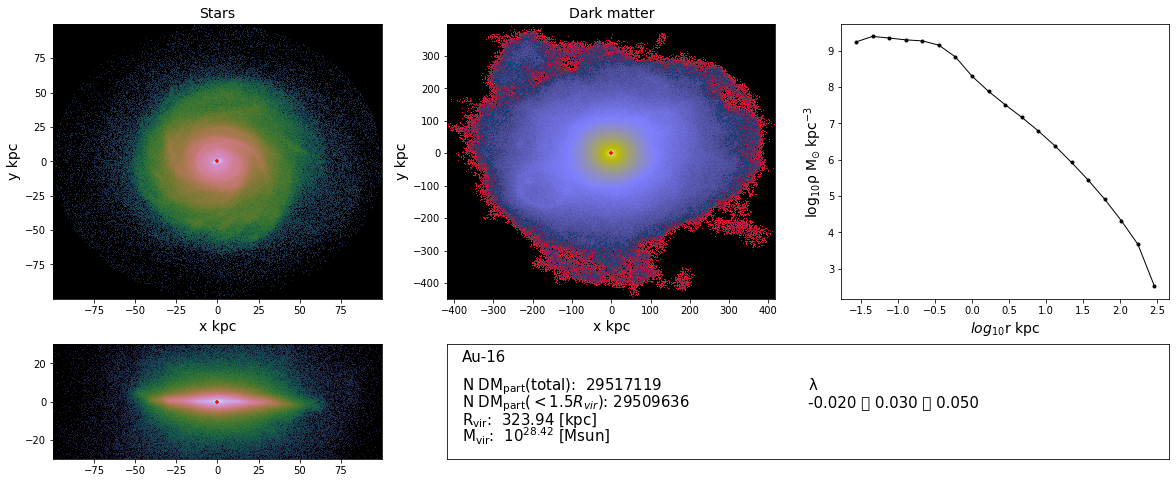

Au-16 snapshot 61
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  29831826 29835630
Lambda_stars:  0.003	0.007	0.156
Lambda_gas:  -0.024	0.075	0.497
Lambda_dm:  -0.024	0.037	0.053


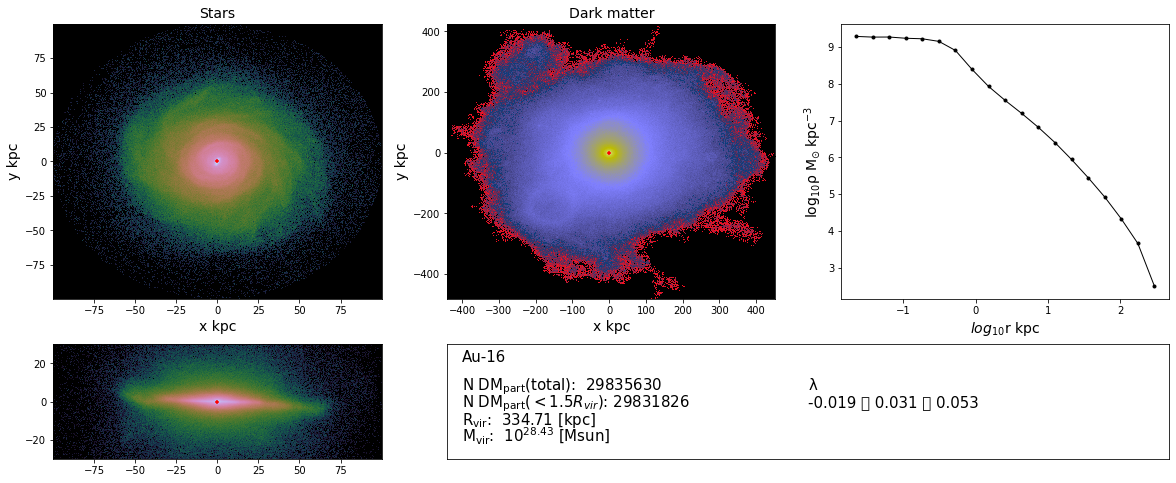

Au-16 snapshot 62
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  30050059 30055432
Lambda_stars:  -0.003	0.001	0.162
Lambda_gas:  -0.056	0.067	0.535
Lambda_dm:  -0.024	0.037	0.054


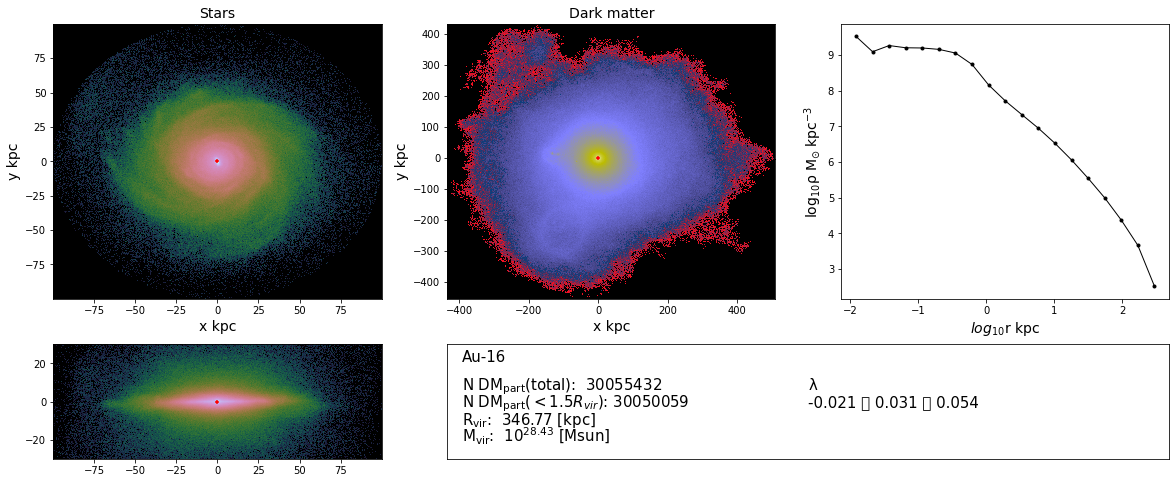

Au-16 snapshot 63
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  30330070 30334251
Lambda_stars:  -0.009	0.006	0.167
Lambda_gas:  -0.091	0.088	0.564
Lambda_dm:  -0.026	0.039	0.052


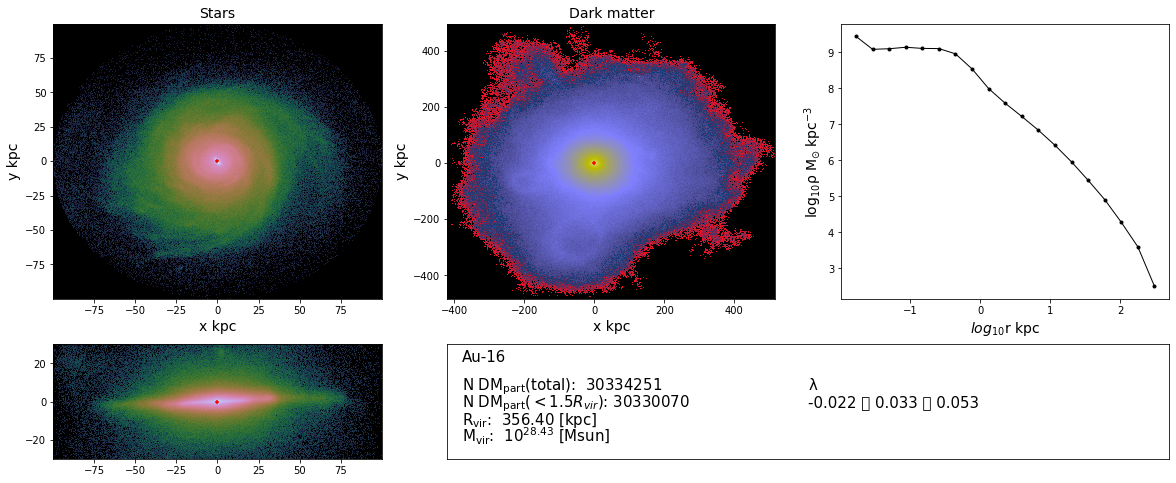

In [4]:
nhalo = 16
Lsnap = np.arange(60,64,1,dtype=int)

#for nhalo in la.L3MHDsam:
for ns in Lsnap:
    
    print('Au-%s snapshot %s'%(nhalo,ns))
    nsnap= 63
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    #def func1(st,f): return sim.Snapshot_Subhalo(idSubhalo=0,snapType=st,fields=f)
    fields_stars = ['pos','vel','id','mass','type','pot','age']
    fields_dm = ['pos','vel','id','mass','type','pot']
    fields_gas = ['pos','vel','id','mass','type','pot']
    #manager = multiprocessing.Manager()
    #return_dict = manager.dict()
    
    #p1 = multiprocessing.Process(target=func1, args=('stars',fields_stars))
    #p2 = multiprocessing.Process(target=func1, args=('dm1',fields_dm))
    #p1.start()
    #p2.start()
    #p1.join()
    #p2.join()
    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars,CalcStellarAges='CalcAgesAlt')
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    Datgas = sim.Snapshot_Subhalo(idSubhalo=0,snapType='gas',fields=fields_gas)
    #print(return_dict.values())
    #break
    #del p1,p2
    
    Data = {'stars':Datstars,'dm1':DatDM,'gas':Datgas}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Rotate()#UseMulti='SerialPool')
    Datstars=Data['stars']
    DatDM = Data['dm1']
    Datgas = Data['gas']
    
    
    # Stellar Parameter -------------------------------
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    
    rs = np.sqrt(Xs**2 + Ys**2)
    rstar = np.sqrt(Xs**2 + Ys**2 +Zs**2)
    
    # DM paramater ------------------------------------
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    rdm= np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    # --------------------------------------------------
    
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    print('DM particles: ',len(r3dm),Npartbe)
    #------------------------------------------------------------------------
    #Compute Lambda
    G= 6.674*1e-11 #m3⋅kg−1⋅s−2
    m2kpc, kg2Msun = 3.2408*1e-20,5e-31
    G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
    
    rgas = np.sqrt(Datgas['pos'][:,0]**2 + Datgas['pos'][:,1]**2 + Datgas['pos'][:,2]**2)
    r200 = Rvir
    sels,selg,seld = (rstar<=r200) , (rgas<=r200) , (rdm<=r200)
    Mencs,Mencg,Mencd=np.sum(Datstars['mass'][sels]), np.sum(Datgas['mass'][selg]), np.sum(DatDM['mass'][seld])
    Menc =  Mencs+Mencg+Mencd
    #print(mass200encl,m200)
    #r X v
    Jstar = AngMom(np.hstack((Datstars['pos'],Datstars['vel'],Datstars['mass'].reshape(Datstars['mass'].size,1)))[sels])
    Jgas  = AngMom(np.hstack((Datgas['pos'],Datgas['vel'],Datgas['mass'].reshape(Datgas['mass'].size,1)))[selg])
    Jdm   = AngMom(np.hstack((DatDM['pos'],DatDM['vel'],DatDM['mass'].reshape(DatDM['mass'].size,1)))[seld])
    ## revisar calculo de J para dm

    J = Jstar+Jgas+Jdm

    #print(Jstar,Jgas,Jdm,J)
    V200 = np.sqrt((G*Menc)/r200)
    V200s,V200g,V200d = np.sqrt((G*Mencs)/r200),np.sqrt((G*Mencg)/r200),np.sqrt((G*Mencd)/r200)
    Lambda = J / (np.sqrt(2)*Menc*r200*V200)
    Ls = Jstar / (np.sqrt(2)*Mencs*r200*V200s)
    Lg = Jgas / (np.sqrt(2)*Mencg*r200*V200g)
    Ld = Jdm / (np.sqrt(2)*Mencd*r200*V200d)
    
    print('Lambda_stars:  %.3f\t%.3f\t%.3f'%(Ls[0],Ls[1],Ls[2]))
    print('Lambda_gas:  %.3f\t%.3f\t%.3f'%(Lg[0],Lg[1],Lg[2]))
    print('Lambda_dm:  %.3f\t%.3f\t%.3f'%(Ld[0],Ld[1],Ld[2]))
    #------------------------------------------------------------------------
    Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
    
    


    plt.figure(figsize=(20,8))
    
    ax1=plt.subplot(3,3,(1,4))
    ax1.patch.set_facecolor('black')
    extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
    plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')
    #plt.title('Au-%s'%nhalo,fontsize=14)
    plt.title('Stars',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    ax2=plt.subplot(3,3,7)
    ax2.patch.set_facecolor('black')
    extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
    plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')

    ax3=plt.subplot(3,3,(2,5))
    ax3.patch.set_facecolor('black')
    extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
    plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=10,c='r',marker='+')
    plt.title('Dark matter',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    plt.subplot(3,3,(3,6))
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)

    plt.plot(DR[:-1],np.log10(rho),lw=1,marker='.',c='k')
    plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
    #print(DR,rho)
    
    plt.subplot(3,3,(8,9))

    plt.text(0.02,0.85,'Au-%s'%nhalo,fontsize=15)
    plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%Npartbe,fontsize=15)
    plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%len(r3dm),fontsize=15)
    plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%Rvir,fontsize=15)
    plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%.2f}$ [Msun]'%np.log(Mvir),fontsize=15)
    plt.text(0.5,0.6,r'$\rm \lambda$',fontsize=15)
    plt.text(0.5,0.45,'%.3f \t %.3f \t %.3f'%(Lambda[0],Lambda[1],Lambda[2]),fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.4)
    plt.savefig('plots/profiles_Au%s.pdf'%nhalo)
    plt.show()
    plt.close()
    '''
    #g1 = hf.create_group('Au-%s'%nhalo)
    hf = h5.File('Table/Data_DM_Au-%s.hdf5'%nhalo,'w')
    hf.create_dataset('x'    ,data=Xdm)
    hf.create_dataset('y'    ,data=Ydm)
    hf.create_dataset('z'    ,data=Zdm)
    hf.create_dataset('m'    ,data=Mdm)
    
    hf.close()'''

    

[63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40
 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20]
Au-16 | snapshot 63 | number 0 | Nyoung 3251686 | Age Universe 13.821
Agestar -0.001 -- 7.778 -- 13.826
Au-16 | snapshot 62 | number 1 | Nyoung 3544722 | Age Universe 13.513
Agestar -0.001 -- 7.507 -- 13.518
Au-16 | snapshot 61 | number 2 | Nyoung 3895701 | Age Universe 13.147
Agestar -0.001 -- 7.181 -- 13.152
Au-16 | snapshot 60 | number 3 | Nyoung 4187795 | Age Universe 12.846
Agestar -0.001 -- 6.916 -- 12.85
Au-16 | snapshot 59 | number 4 | Nyoung 4547166 | Age Universe 12.489
Agestar -0.001 -- 6.603 -- 12.493
Au-16 | snapshot 58 | number 5 | Nyoung 4935003 | Age Universe 12.137
Agestar -0.001 -- 6.293 -- 12.141
Au-16 | snapshot 57 | number 6 | Nyoung 5287202 | Age Universe 11.848
Agestar -0.0 -- 6.04 -- 11.852
Au-16 | snapshot 56 | number 7 | Nyoung 5725628 | Age Universe 11.506
Agestar -0.0 -- 5.745 -- 11.51
Au-16 | snapshot 55 | number 8 | Nyoung 

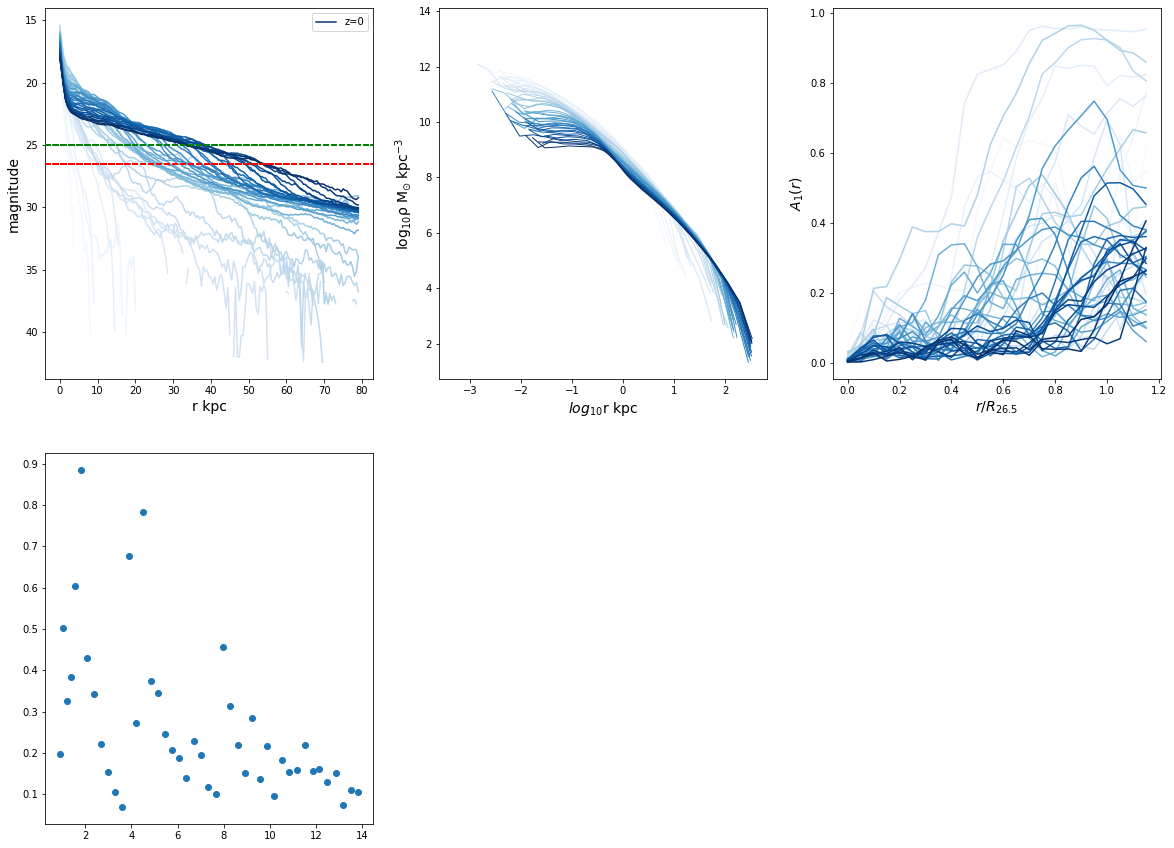

Au-21 | snapshot 63 | number 0 | Nyoung 5825481 | Age Universe 13.821
Agestar -0.001 -- 6.559 -- 13.826
Au-21 | snapshot 62 | number 1 | Nyoung 6332548 | Age Universe 13.481
Agestar -0.001 -- 6.277 -- 13.486
Au-21 | snapshot 61 | number 2 | Nyoung 6877259 | Age Universe 13.145
Agestar -0.0 -- 6.001 -- 13.15
Au-21 | snapshot 60 | number 3 | Nyoung 7142406 | Age Universe 12.813
Agestar -0.001 -- 5.759 -- 12.817
Au-21 | snapshot 59 | number 4 | Nyoung 7567830 | Age Universe 12.485
Agestar -0.001 -- 5.513 -- 12.489
Au-21 | snapshot 58 | number 5 | Nyoung 8081318 | Age Universe 12.161
Agestar -0.0 -- 5.261 -- 12.166
Au-21 | snapshot 57 | number 6 | Nyoung 8207469 | Age Universe 11.842
Agestar -0.001 -- 5.035 -- 11.846
Au-21 | snapshot 56 | number 7 | Nyoung 8611020 | Age Universe 11.527
Agestar -0.001 -- 4.767 -- 11.531
Au-21 | snapshot 55 | number 8 | Nyoung 9141789 | Age Universe 11.156
Agestar -0.0 -- 4.458 -- 11.16
Au-21 | snapshot 54 | number 9 | Nyoung 9948647 | Age Universe 10.852
Ag

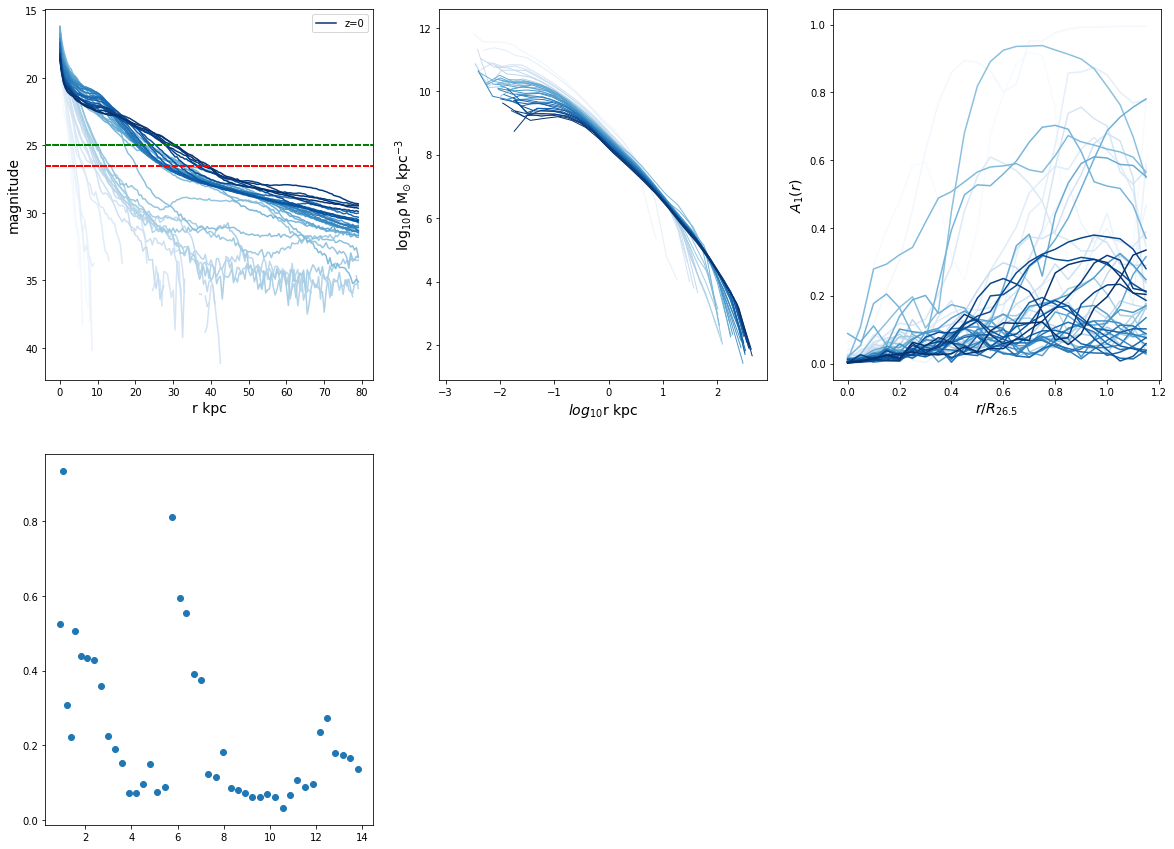

Au-23 | snapshot 63 | number 0 | Nyoung 4710318 | Age Universe 13.821
Agestar -0.001 -- 7.971 -- 13.826
Au-23 | snapshot 62 | number 1 | Nyoung 4769695 | Age Universe 13.481
Agestar -0.001 -- 7.663 -- 13.486
Au-23 | snapshot 61 | number 2 | Nyoung 4853419 | Age Universe 13.145
Agestar -0.0 -- 7.365 -- 13.15
Au-23 | snapshot 60 | number 3 | Nyoung 4980858 | Age Universe 12.813
Agestar -0.001 -- 7.076 -- 12.817
Au-23 | snapshot 59 | number 4 | Nyoung 5087870 | Age Universe 12.485
Agestar -0.001 -- 6.794 -- 12.489
Au-23 | snapshot 58 | number 5 | Nyoung 5173156 | Age Universe 12.161
Agestar -0.0 -- 6.523 -- 12.166
Au-23 | snapshot 57 | number 6 | Nyoung 5209977 | Age Universe 11.842
Agestar -0.001 -- 6.263 -- 11.846
Au-23 | snapshot 56 | number 7 | Nyoung 5375534 | Age Universe 11.527
Agestar -0.001 -- 6.023 -- 11.531
Au-23 | snapshot 55 | number 8 | Nyoung 6033213 | Age Universe 11.156
Agestar -0.0 -- 5.759 -- 11.16
Au-23 | snapshot 54 | number 9 | Nyoung 6450209 | Age Universe 10.852
Ag

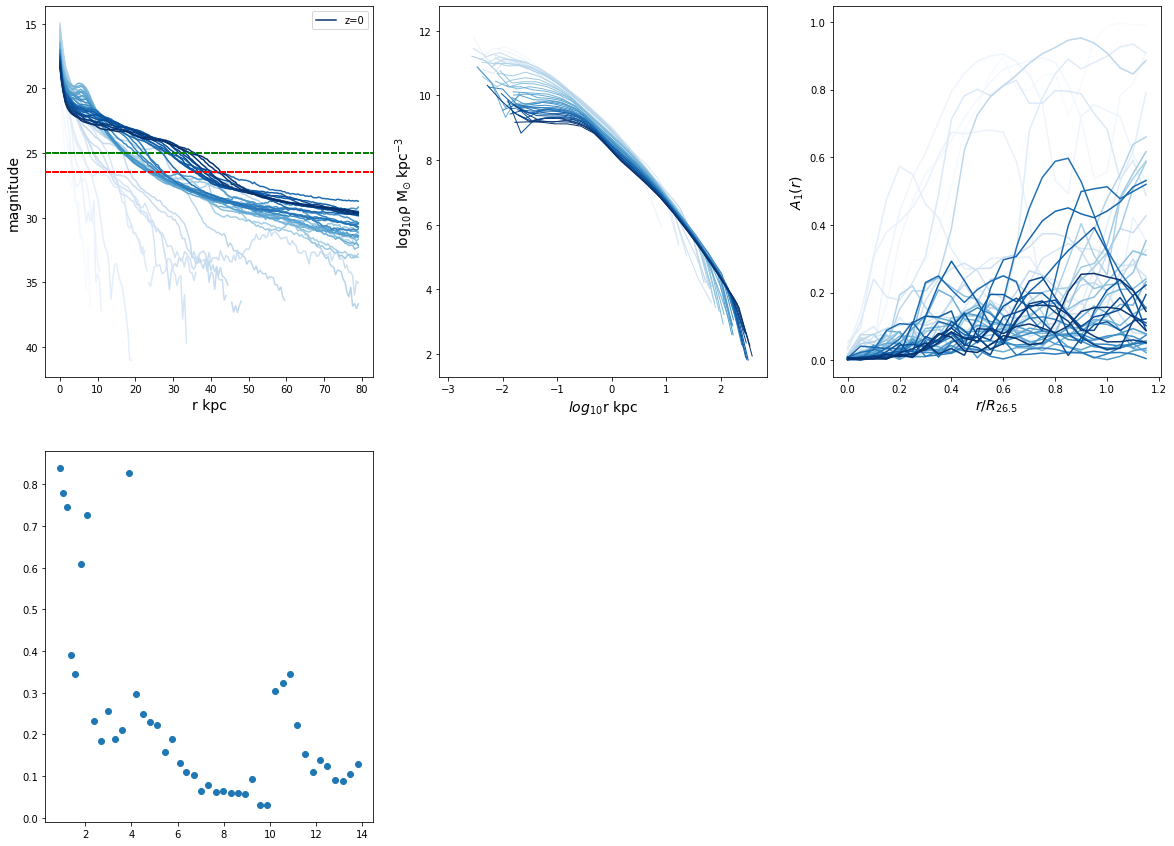

Au-24 | snapshot 63 | number 0 | Nyoung 4730536 | Age Universe 13.821
Agestar -0.001 -- 7.444 -- 13.826
Au-24 | snapshot 62 | number 1 | Nyoung 5238753 | Age Universe 13.481
Agestar -0.001 -- 7.151 -- 13.486
Au-24 | snapshot 61 | number 2 | Nyoung 5675513 | Age Universe 13.145
Agestar -0.0 -- 6.866 -- 13.15
Au-24 | snapshot 60 | number 3 | Nyoung 6169544 | Age Universe 12.813
Agestar -0.001 -- 6.596 -- 12.817
Au-24 | snapshot 59 | number 4 | Nyoung 6586807 | Age Universe 12.485
Agestar -0.001 -- 6.365 -- 12.489
Au-24 | snapshot 58 | number 5 | Nyoung 7132909 | Age Universe 12.161
Agestar -0.0 -- 6.129 -- 12.166
Au-24 | snapshot 57 | number 6 | Nyoung 7565088 | Age Universe 11.842
Agestar -0.001 -- 5.923 -- 11.846
Au-24 | snapshot 56 | number 7 | Nyoung 8160175 | Age Universe 11.527
Agestar -0.001 -- 5.707 -- 11.531
Au-24 | snapshot 55 | number 8 | Nyoung 8355785 | Age Universe 11.156
Agestar -0.0 -- 5.515 -- 11.16
Au-24 | snapshot 54 | number 9 | Nyoung 8342209 | Age Universe 10.852
Ag

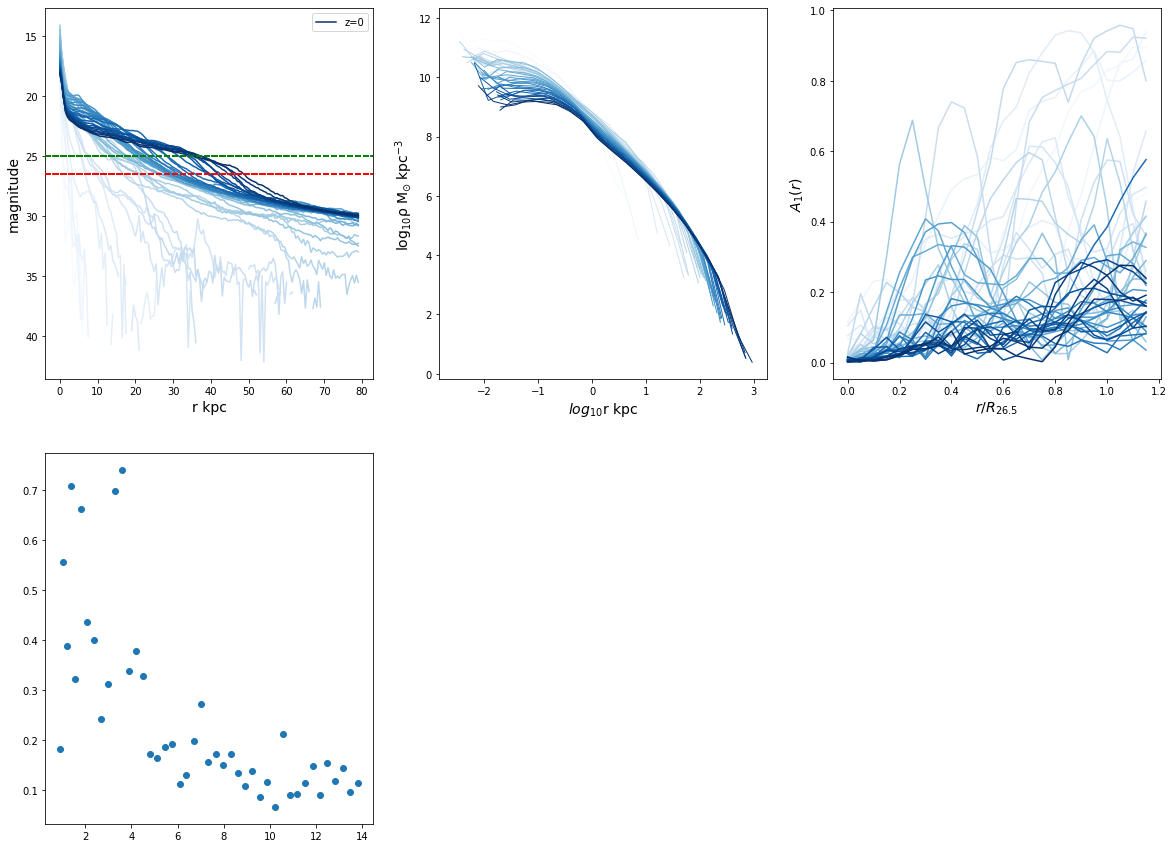

Au-27 | snapshot 63 | number 0 | Nyoung 4996960 | Age Universe 13.821
Agestar -0.001 -- 8.035 -- 13.826
Au-27 | snapshot 62 | number 1 | Nyoung 5357568 | Age Universe 13.481
Agestar -0.001 -- 7.741 -- 13.486
Au-27 | snapshot 61 | number 2 | Nyoung 5667392 | Age Universe 13.145
Agestar -0.0 -- 7.46 -- 13.15
Au-27 | snapshot 60 | number 3 | Nyoung 5840384 | Age Universe 12.813
Agestar -0.001 -- 7.187 -- 12.817
Au-27 | snapshot 59 | number 4 | Nyoung 6234082 | Age Universe 12.485
Agestar -0.001 -- 6.915 -- 12.489
Au-27 | snapshot 58 | number 5 | Nyoung 6710335 | Age Universe 12.161
Agestar -0.0 -- 6.645 -- 12.166
Au-27 | snapshot 57 | number 6 | Nyoung 7112810 | Age Universe 11.842
Agestar -0.001 -- 6.395 -- 11.846
Au-27 | snapshot 56 | number 7 | Nyoung 7328880 | Age Universe 11.527
Agestar -0.001 -- 6.154 -- 11.531
Au-27 | snapshot 55 | number 8 | Nyoung 7873682 | Age Universe 11.156
Agestar -0.0 -- 5.853 -- 11.16
Au-27 | snapshot 54 | number 9 | Nyoung 8155847 | Age Universe 10.852
Age

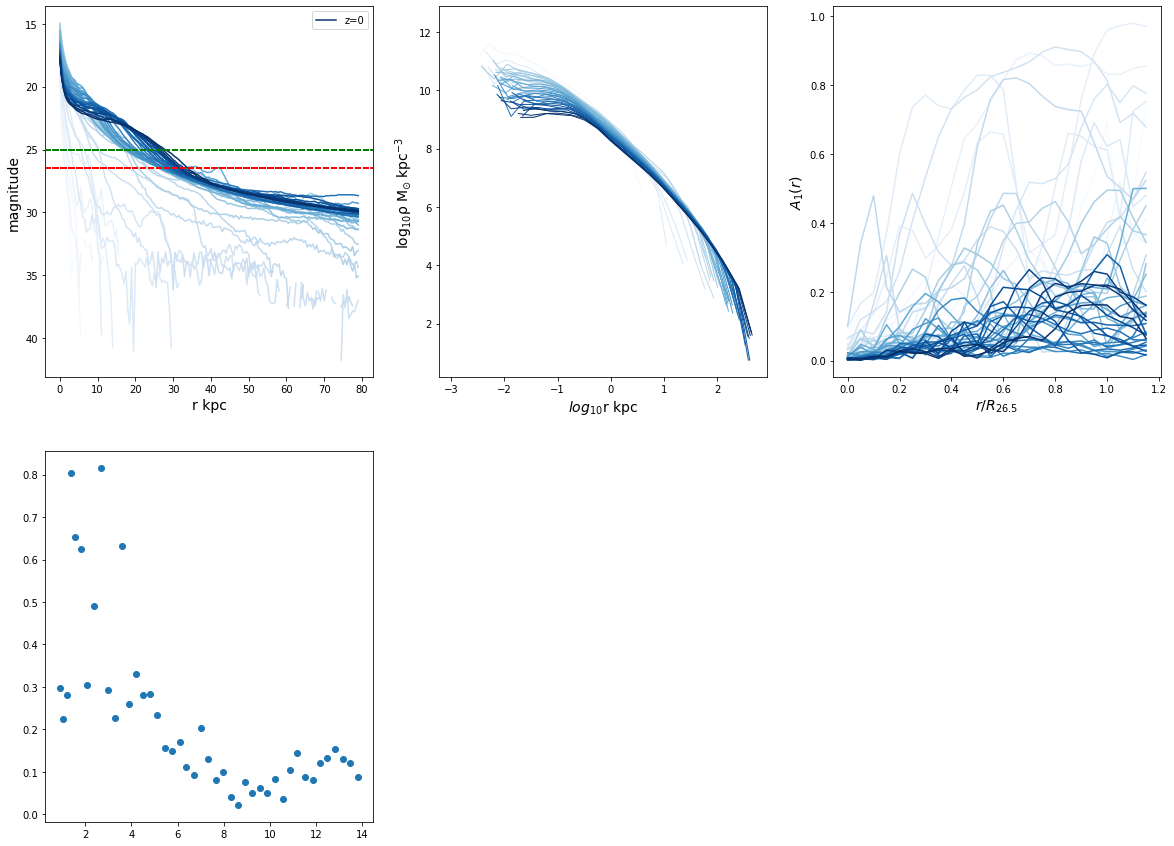

Au-6 | snapshot 63 | number 0 | Nyoung 3028368 | Age Universe 13.821
Agestar -0.001 -- 7.41 -- 13.826
Au-6 | snapshot 62 | number 1 | Nyoung 3271176 | Age Universe 13.481
Agestar -0.001 -- 7.091 -- 13.486
Au-6 | snapshot 61 | number 2 | Nyoung 3665574 | Age Universe 13.145
Agestar -0.0 -- 6.776 -- 13.15
Au-6 | snapshot 60 | number 3 | Nyoung 4440393 | Age Universe 12.813
Agestar -0.001 -- 6.462 -- 12.817
Au-6 | snapshot 59 | number 4 | Nyoung 5058583 | Age Universe 12.485
Agestar -0.001 -- 6.154 -- 12.489
Au-6 | snapshot 58 | number 5 | Nyoung 5601208 | Age Universe 12.161
Agestar -0.0 -- 5.857 -- 12.166
Au-6 | snapshot 57 | number 6 | Nyoung 6185913 | Age Universe 11.842
Agestar -0.001 -- 5.565 -- 11.846
Au-6 | snapshot 56 | number 7 | Nyoung 6843817 | Age Universe 11.527
Agestar -0.001 -- 5.276 -- 11.531
Au-6 | snapshot 55 | number 8 | Nyoung 7439176 | Age Universe 11.156
Agestar -0.0 -- 4.95 -- 11.16
Au-6 | snapshot 54 | number 9 | Nyoung 7798990 | Age Universe 10.852
Agestar -0.0 -

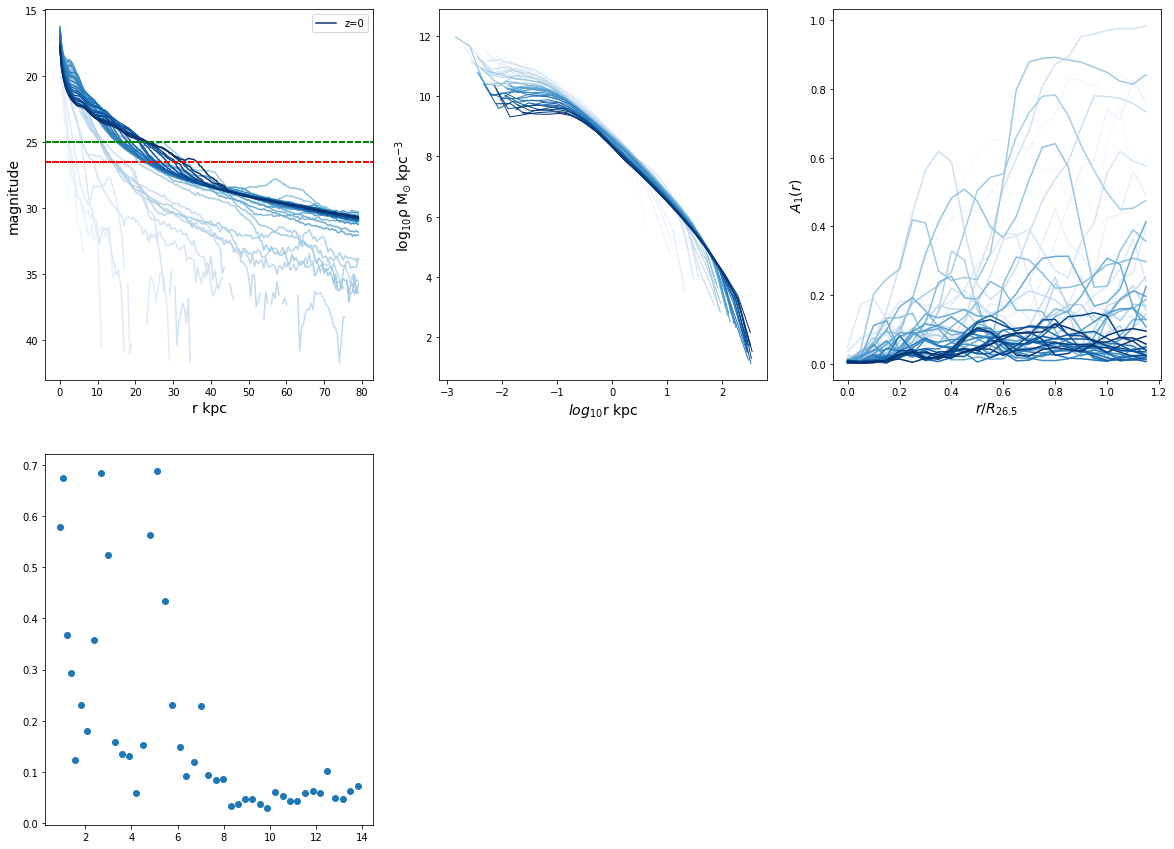

In [5]:
import matplotlib.pylab as pl
#nhalo = 16
Lsnap = np.arange(20,64,1,dtype=int)[::-1]
print(Lsnap)

#plt.subplots_adjust(hspace=0.4)

for nhalo in la.L3MHDsam:
  colors = pl.cm.Blues(np.linspace(0,1,len(Lsnap)))[::-1]

  plt.figure(figsize=(20,15))
  ax1=plt.subplot(2,3,1)
  ax2=plt.subplot(2,3,2)
  ax3=plt.subplot(2,3,3)
  ax4=plt.subplot(2,3,4)
  #if nhalo!=16:continue
  #print('halo ID ',nhalo)
  A1Med,LageU=[],[]
  
  for ii,ns in enumerate(Lsnap):
    
    #print('Au-%s snapshot %s number %s'%(nhalo,ns,ii),end='\r')
    #print(colors[ii])
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    fields_stars = ['pos','vel','id','mass','type','pot','age','gsph']
    fields_dm = ['pos','vel','id','mass','type','pot']

    

    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars,CalcStellarAges='CalcAgesAlt')
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    #print('Age of Universe %s Gyr'%round(sim.AgeU,3),end='\r')
    LageU.append(sim.AgeU)
    
    #print('edad ',len(Datstars['age']),max(Datstars['age']),min(Datstars['age']))
    Data = {'stars':Datstars,'dm1':DatDM}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    #print('rotar')
    nans = np.isnan(Datstars['age'])
    agelimit = np.percentile(Datstars['age'][~nans],25)
    agemin,agemax,agemed=np.nanmin(Datstars['age']),np.nanmax(Datstars['age']),np.median(Datstars['age'][~nans])
    Nyoung = np.sum(Datstars['age'][~nans]<5)
    gal = la.ToolRot(Data=Data, param=param)#,agelim=agelimit  )
    Data = gal.Rotate()
    Datstars=Data['stars']
    DatDM = Data['dm1']
    #print('fin rotar')
    
    
    # Stellar Parameter ==============================================
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    photpart = Datstars['gsph']
    rs = np.sqrt(Xs**2 + Ys**2)
    rstar = np.sqrt(Xs**2 + Ys**2 +Zs**2)
    #print('Nstar %s'%len(rstar),end='\r')
    #----------SB profile
    rsd,mvs = la.StellarDensity1D(rs,photpart[:,2],lmax=80)
    if ns==63: ax1.plot(rsd,mvs,color=colors[ii],label='z=0',zorder=ns)
    else:ax1.plot(rsd,mvs,color=colors[ii],zorder=ns)
    ax1.axhline(26.5,ls='--',c='r',zorder=70)
    ax1.axhline(25,ls='--',c='g',zorder=71)
    
    ax1.set_xlabel(r'r kpc',fontsize=14)
    ax1.set_ylabel(r'magnitude',fontsize=14)
    ax1.legend()
    
    #----------optical radius
    ropt = la.Ropts(rsd,mvs,mag=25)
    rholm = la.Ropts(rsd,mvs,mag=26.5)
    #----------MFourier A1
    fstar=np.array([Xs,Ys,Zs,Xs,Ys,Zs,Ms])
    Subhalo0= la.Asymmetry(stars_data=fstar.T,dm_data=None)
    #fstar: [x,y,z,vx,vy,vz,m,age,idstar,Metal,U,B,V,K,g,r,i,z_]
    _,distr_A1 = Subhalo0.Mfourier(Ropt=rholm,r_min=0,r_max=1.2,r_int=0.05)
    median_A1,_ = Subhalo0.Mfourier(Ropt=rholm,r_min=0.4,r_max=1.2,r_int=0.05)
    ax3.plot(distr_A1[0],distr_A1[1],color=colors[ii],zorder=ns)
    ax3.set_xlabel(r'$r/R_{26.5}$',fontsize=14)
    ax3.set_ylabel(r'$A_1(r)$',fontsize=14)
    #ax3.set_ylim(0,0.2)
    A1Med.append(median_A1)
    del fstar
    # DM paramater ==============================================
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    rdm= np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)
        
    ax2.plot(DR[:-1],np.log10(rho),color=colors[ii],lw=1,zorder=ns)
    ax2.set_ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    ax2.set_xlabel(r'$log_{10}$r kpc',fontsize=14)
    # --------------------------------------------------
    
    print('Au-%s | snapshot %s | number %s | Nyoung %s | Age Universe %s'%(nhalo,ns,ii,Nyoung,round(sim.AgeU,3)))
    print('Agestar %s -- %s -- %s'%(round(agemin,3),round(agemed,3),round(agemax,3)))
    '''
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    
    r200 = Rvir
    sels,seld = (rstar<=r200) , (rdm<=r200)'''


    #------------------------------------------------------------------------
    #Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    #Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    #Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
  yl=ax1.get_ylim()
  ax1.set_ylim(yl[::-1])  
  A1Med=np.array(A1Med)
  ax4.scatter(LageU,A1Med)
  plt.show()
  plt.close()
    

In [6]:
for ii,ns in enumerate(Lsnap):
    
    print('Au-%s snapshot %s number %s'%(nhalo,ns,ii))
    #print(colors[ii])
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    print(header['redshift'],ns)

Au-6 snapshot 63 number 0
2.220446049250313e-16 63
Au-6 snapshot 62 number 1
0.023974428382762536 62
Au-6 snapshot 61 number 2
0.04852362998180593 61
Au-6 snapshot 60 number 3
0.07366138465643868 60
Au-6 snapshot 59 number 4
0.09940180263022191 59
Au-6 snapshot 58 number 5
0.12575933241126092 58
Au-6 snapshot 57 number 6
0.15274876890238098 57
Au-6 snapshot 56 number 7
0.1803852617057493 56
Au-6 snapshot 55 number 8
0.21442503551449454 55
Au-6 snapshot 54 number 9
0.24354018155467028 54
Au-6 snapshot 53 number 10
0.2733533465784399 53
Au-6 snapshot 52 number 11
0.31007412012783386 52
Au-6 snapshot 51 number 12
0.3478538418581776 51
Au-6 snapshot 50 number 13
0.38016786726023866 50
Au-6 snapshot 49 number 14
0.41996894199726653 49
Au-6 snapshot 48 number 15
0.4609177941806475 48
Au-6 snapshot 47 number 16
0.5030475232448832 47
Au-6 snapshot 46 number 17
0.5463921831410221 46
Au-6 snapshot 45 number 18
0.5985432881875667 45
Au-6 snapshot 44 number 19
0.6446418406845371 44
Au-6 snapshot 4

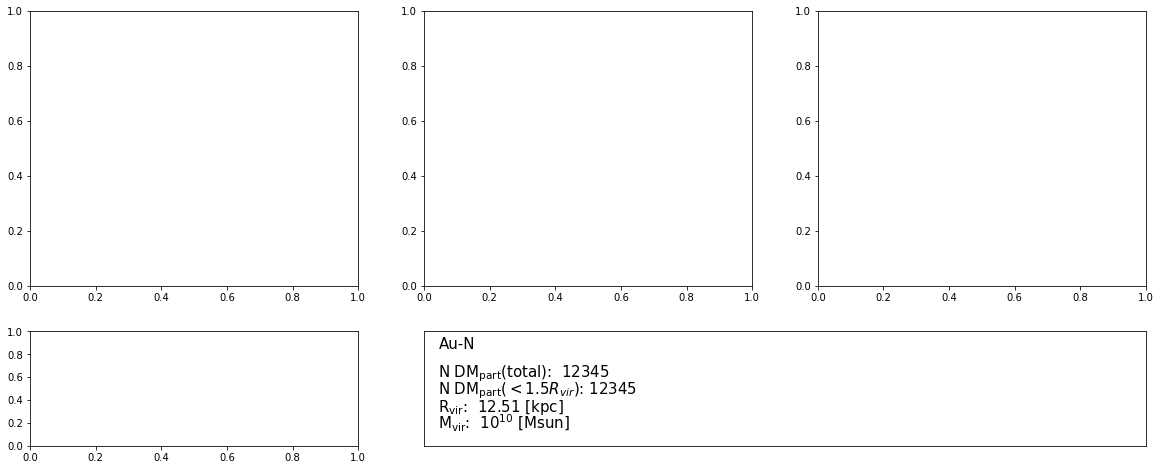

In [7]:
plt.figure(figsize=(20,8))
plt.subplot(3,3,(1,4))

plt.subplot(3,3,7)

plt.subplot(3,3,(2,5))

plt.subplot(3,3,(3,6))

plt.subplot(3,3,(8,9))

plt.text(0.02,0.85,'Au-N',fontsize=15)
plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%12345,fontsize=15)
plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%12345,fontsize=15)
plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%12.512345,fontsize=15)
plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%s}$ [Msun]'%10,fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()

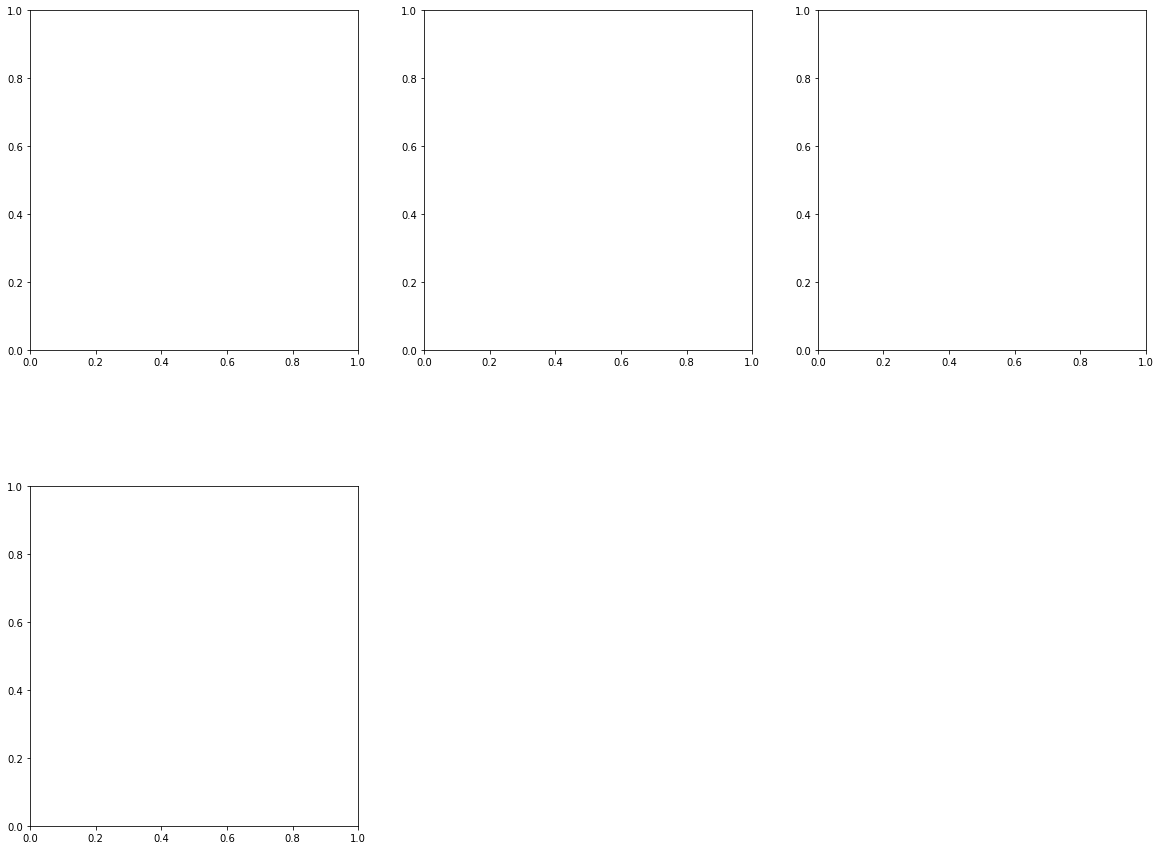

In [8]:
plt.figure(figsize=(20,15))
plt.subplot(2,3,1)

plt.subplot(2,3,2)

plt.subplot(2,3,3)

plt.subplot(2,3,4)



plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()